In [1]:
# Predicting Customer Churn

# Importing packages

In [2]:
import pandas as pd
import numpy as np

import plotly.express as px

# Data Pre-processing

## Reading dataset

In [3]:
train_data = pd.read_csv('https://raw.githubusercontent.com/mmcuri/ds_handson/master/data/telecom/WA_Fn-UseC_-Telco-Customer-Churn.csv')
train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
train_data.shape

(7043, 21)

In [5]:
# let's look at the statistical aspects of the dataframe
train_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Let's see the type of each column
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Preparation

#### Separating numerical and categorical columns

In [7]:
### Functions

# This function is used to separate categorical and float columns
def num_cat_cols(df):
  cols = df.columns
  num_cols = df._get_numeric_data().columns
  cat_cols = list(set(cols) - set(num_cols))
  num_cols = list(num_cols)
  if len(num_cols) + len(cat_cols) == len(cols):
    pass
  else:
    print('Some columns missing')
  return num_cols, cat_cols


# Categorical columns above a certain unique count will be skipped and not added to the OHE or Label Encoder
def displaying_OHE_cols(df,cat_cols,nunique_val):
  column_skipped = []
  
  for i in cat_cols:
    if df[i].nunique() > nunique_val:
      column_skipped.append(i)
    else:
      print('Column being analysed is '+i)
      display(df[i].value_counts())
      print('-------------------------------------------------')

  print('Columns that are skipped ',column_skipped)
  return column_skipped

# This function OHE the given list of column while dropping the redundant column
def ohe(df, col):

  def ohe_prep(main_data, col_ohe, prefx):
    bridge_df = main_data[[col_ohe]]
    # generate binary values using get_dummies
    dum_df = pd.get_dummies(bridge_df, columns=[col_ohe], prefix=[prefx] , drop_first=True)
    # merge with main df bridge_df on key values
    del main_data[col_ohe]
    return main_data.join(dum_df)

  for i in col:
    df = ohe_prep(df,i,i)
  return df

# Checking if we did not loose any column in the split
def split_check(cols):
  missed_cols = list(set(cols) - set(list(num_cols)+list(column_skipped)+ list(ohe_list) + list(le_cols)))
  if len(missed_cols) == 0:
    print('Check!')
  else:
    print("Some columns are missing from the final list are ", missed_cols)

In [8]:
cols = train_data.columns

# Splitting numeric and cat columns
num_cols, cat_cols = num_cat_cols(train_data)

# Display cat cols to be labelled
column_skipped = displaying_OHE_cols(train_data,cat_cols,10)

Column being analysed is PaymentMethod


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

-------------------------------------------------
Column being analysed is InternetService


Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

-------------------------------------------------
Column being analysed is StreamingTV


No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

-------------------------------------------------
Column being analysed is OnlineSecurity


No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

-------------------------------------------------
Column being analysed is TechSupport


No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

-------------------------------------------------
Column being analysed is Churn


No     5174
Yes    1869
Name: Churn, dtype: int64

-------------------------------------------------
Column being analysed is DeviceProtection


No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

-------------------------------------------------
Column being analysed is Dependents


No     4933
Yes    2110
Name: Dependents, dtype: int64

-------------------------------------------------
Column being analysed is MultipleLines


No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

-------------------------------------------------
Column being analysed is Contract


Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

-------------------------------------------------
Column being analysed is PaperlessBilling


Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

-------------------------------------------------
Column being analysed is PhoneService


Yes    6361
No      682
Name: PhoneService, dtype: int64

-------------------------------------------------
Column being analysed is Partner


No     3641
Yes    3402
Name: Partner, dtype: int64

-------------------------------------------------
Column being analysed is StreamingMovies


No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

-------------------------------------------------
Column being analysed is gender


Male      3555
Female    3488
Name: gender, dtype: int64

-------------------------------------------------
Column being analysed is OnlineBackup


No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

-------------------------------------------------
Columns that are skipped  ['TotalCharges', 'customerID']


In [9]:
# Declaring the columns which would be label encoded
le_cols = []

# Creating the OHE list 
ohe_list = list(set(cat_cols) - set(column_skipped) - set(le_cols))

# Checking the split
split_check(cols)

Check!


### Treating OHE columns

In [10]:
# Types of columns we have
# num_cols, column_skipped, ohe_list, le_cols

In [11]:
# OHE region data
train_data = ohe(train_data, ohe_list)

### Treating skipped columns

In [12]:
column_skipped

['TotalCharges', 'customerID']

In [13]:
train_data['TotalCharges'][0]

'29.85'

In [14]:
# As we see the column is object because the values are in string format
# Checking the unique values
train_data['TotalCharges'].nunique()

6531

In [15]:
# This clears that it is a float column in the string format
train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'],errors='coerce')

In [16]:
## Removing 'TotalCharges' from the column_skipped list and adding it to the numeric list
column_skipped.remove('TotalCharges')
num_cols.append('TotalCharges')

In [17]:
# Checking the unique values
train_data['customerID'].nunique()

7043

In [18]:
# As we see this equalls to the number of rows in the table, so this is the unique identifier
# We can drop this column as this would not effect anything, and index can be used as the unique identifier
del train_data['customerID']

### Treating numerical columns

In [19]:
num_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [20]:
train_data['SeniorCitizen'].unique()

array([0, 1])

In [21]:
# This column should be in the OHE columns
num_cols.remove('SeniorCitizen')
ohe_list.append('SeniorCitizen')

In [22]:
train_data['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39])

In [23]:
# We can move this column to the le_cols list
num_cols.remove('tenure')
le_cols.append('tenure')

In [24]:
train_data[num_cols].head()

,MonthlyCharges,TotalCharges
0,29.85,29.85
1,56.95,1889.50
2,53.85,108.15
3,42.30,1840.75
4,70.70,151.65


In [25]:
# Generating a box plot to see if there are any outliers in the numerical values
for col in num_cols:
  fig = px.box(train_data, y=col)
  fig.show()

In [26]:
# Nothing overflowing so that's great

### Treating LE cols

In [27]:
train_data[le_cols[0]].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39])

In [28]:
train_data[le_cols[0]].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

In [29]:
# Internal class imbalance but no treatement required

In [30]:
# Finally, checking the split
split_check(cols)

Check!


### Check for nulls

In [31]:
list(train_data.columns[train_data.isna().any()])

['TotalCharges']

In [32]:
train_data[train_data['TotalCharges'].isna()].shape[0]

11

In [33]:
# These are only 11 rows, we can directly replace them with the average value from the column.
# Dropping these rows might cause an issue when treating the testing dataset.
train_data['TotalCharges'] = train_data['TotalCharges'].replace(np.nan, np.mean(train_data['TotalCharges']))

In [34]:
cols

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [35]:
train_data.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes', 'Churn_Yes',
       'Dependents_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'PaperlessBilling_Yes', 'Contract_One year',
       'Contract_Two year', 'PhoneService_Yes', 'Partner_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'gender_Male', 'OnlineBackup_No internet service', 'OnlineBackup_Yes'],
      dtype='object')

# Test-Train Split

In [36]:
from sklearn.model_selection import train_test_split

In [73]:
# X-train
x_train_array = train_data.copy()
del x_train_array['Churn_Yes']
# x_train_array = x_train_array.values

# Y-train
y_train_array = train_data['Churn_Yes'].copy()
# y_train_array = y_train_array.values

In [74]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_train_array, y_train_array, test_size=0.30, random_state=32,shuffle=True)

# Feature Scaling

In [70]:
from sklearn import preprocessing

In [78]:
# Preventing data leakage while doing a standard scalar
scaler = preprocessing.StandardScaler()
x_train[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(x_train[['tenure','MonthlyCharges','TotalCharges']])
x_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(x_test[['tenure','MonthlyCharges','TotalCharges']])

In [94]:
### Checking the Churn Rate and the class imbalance
churn = (sum(y_train)/len(y_train.index))*100
print('Percentage of churn in the acutal dataset', churn,'%')

Percentage of churn in the acutal dataset 25.436105476673426 %


# Looking at Correlations

In [100]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [130]:
master_train = x_train.copy()
master_train['Churn_Yes'] = y_train

In [131]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                  print(colname)
                  del dataset[colname] # deleting the column from the dataset

    # print(dataset.columns)

In [132]:
correlation(master_train, 0.85)

StreamingTV_No internet service
OnlineSecurity_No internet service
TechSupport_No internet service
DeviceProtection_No internet service
PhoneService_Yes
StreamingMovies_No internet service
OnlineBackup_No internet service


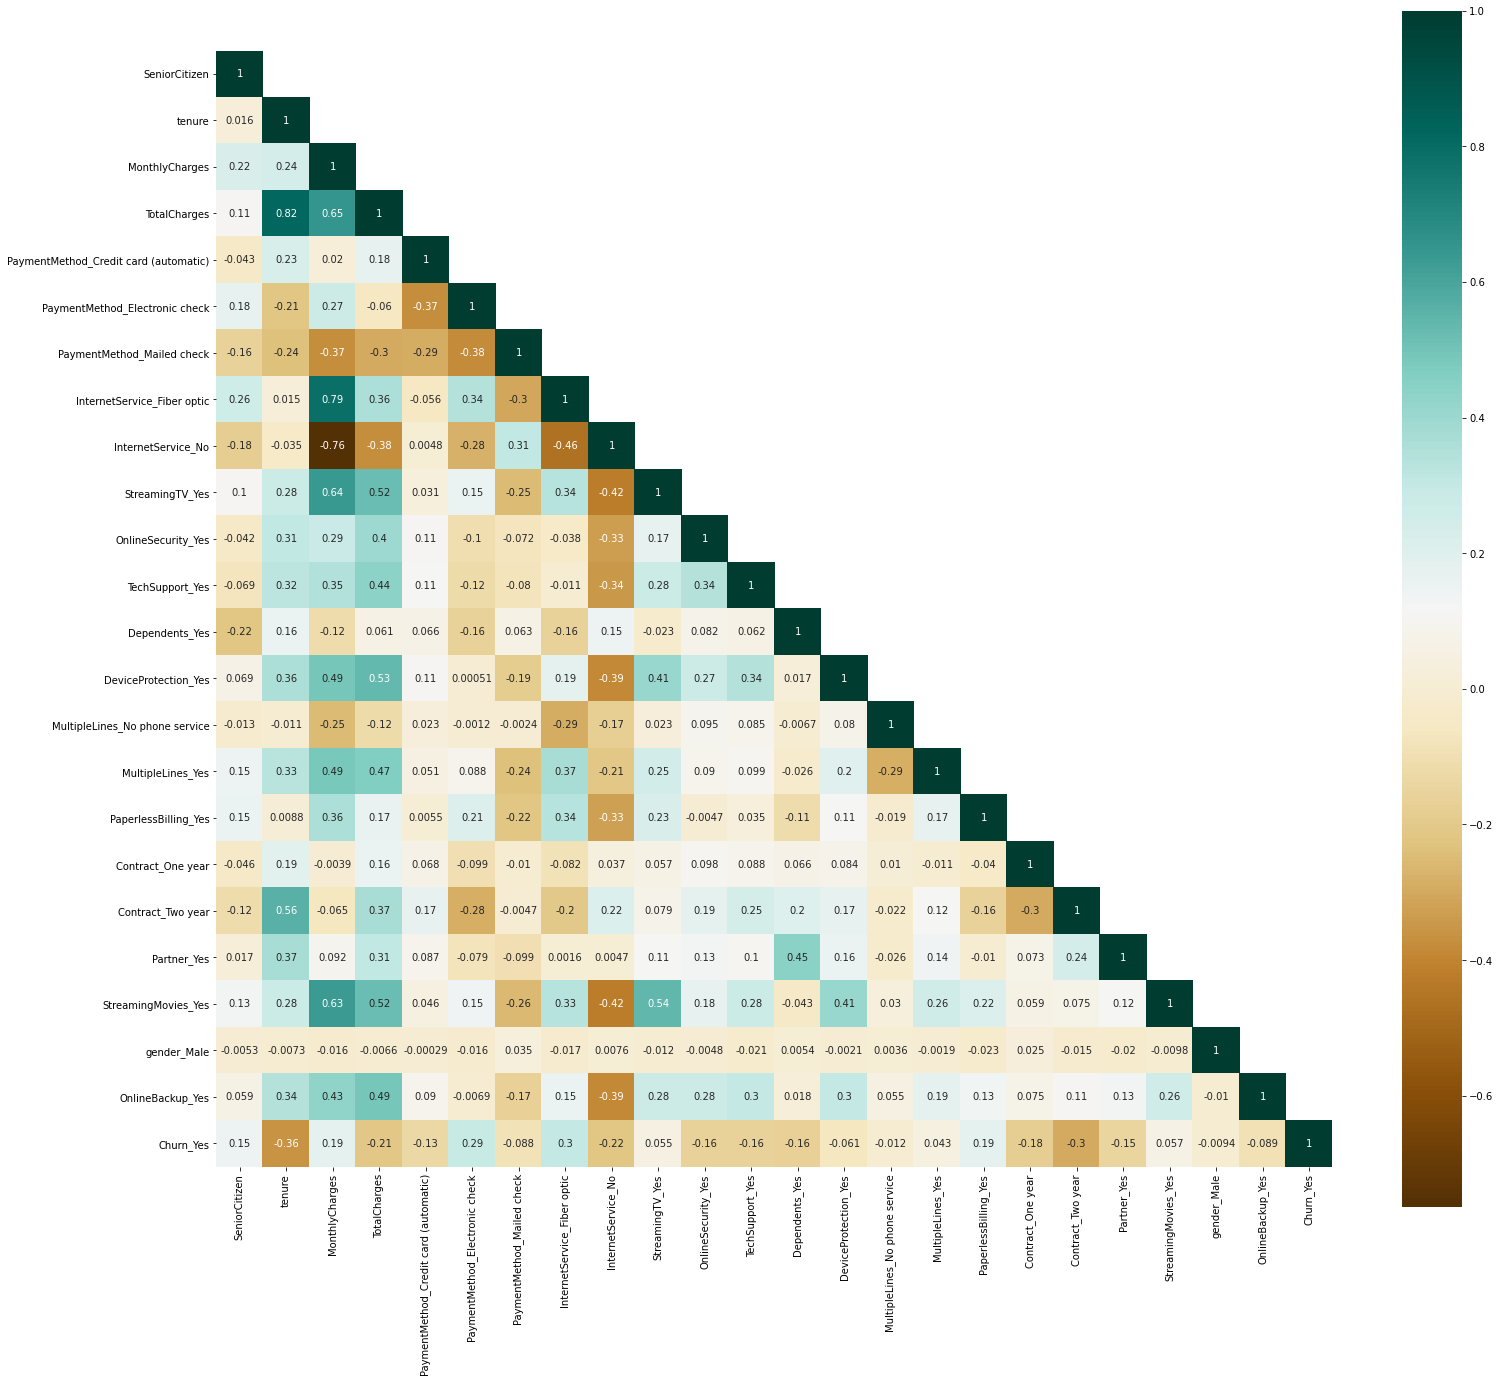

In [133]:
cor_mat= master_train.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(25,22)
sns.heatmap(cor_mat,mask=mask,square=True,annot=True,cbar=True,cmap="BrBG")
plt.show()

## Dropping highly correlated dummy variables

In [ ]:
X_test = X_test.drop(['MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service',
'DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service',
'StreamingMovies_No internet service'], 1)

X_train = X_train.drop(['MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service',
'DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service',
'StreamingMovies_No internet service'], 1)

In [ ]:
telecom_new.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
# 'MultipleLines_No phone service','OnlineSecurity_No internet service','OnlineBackup_No internet service',
# 'DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service',
# 'StreamingMovies_No internet service'

## Checking the Correlation Matrix
### After dropping highly correlated variables now let's check the correlation matrix again.

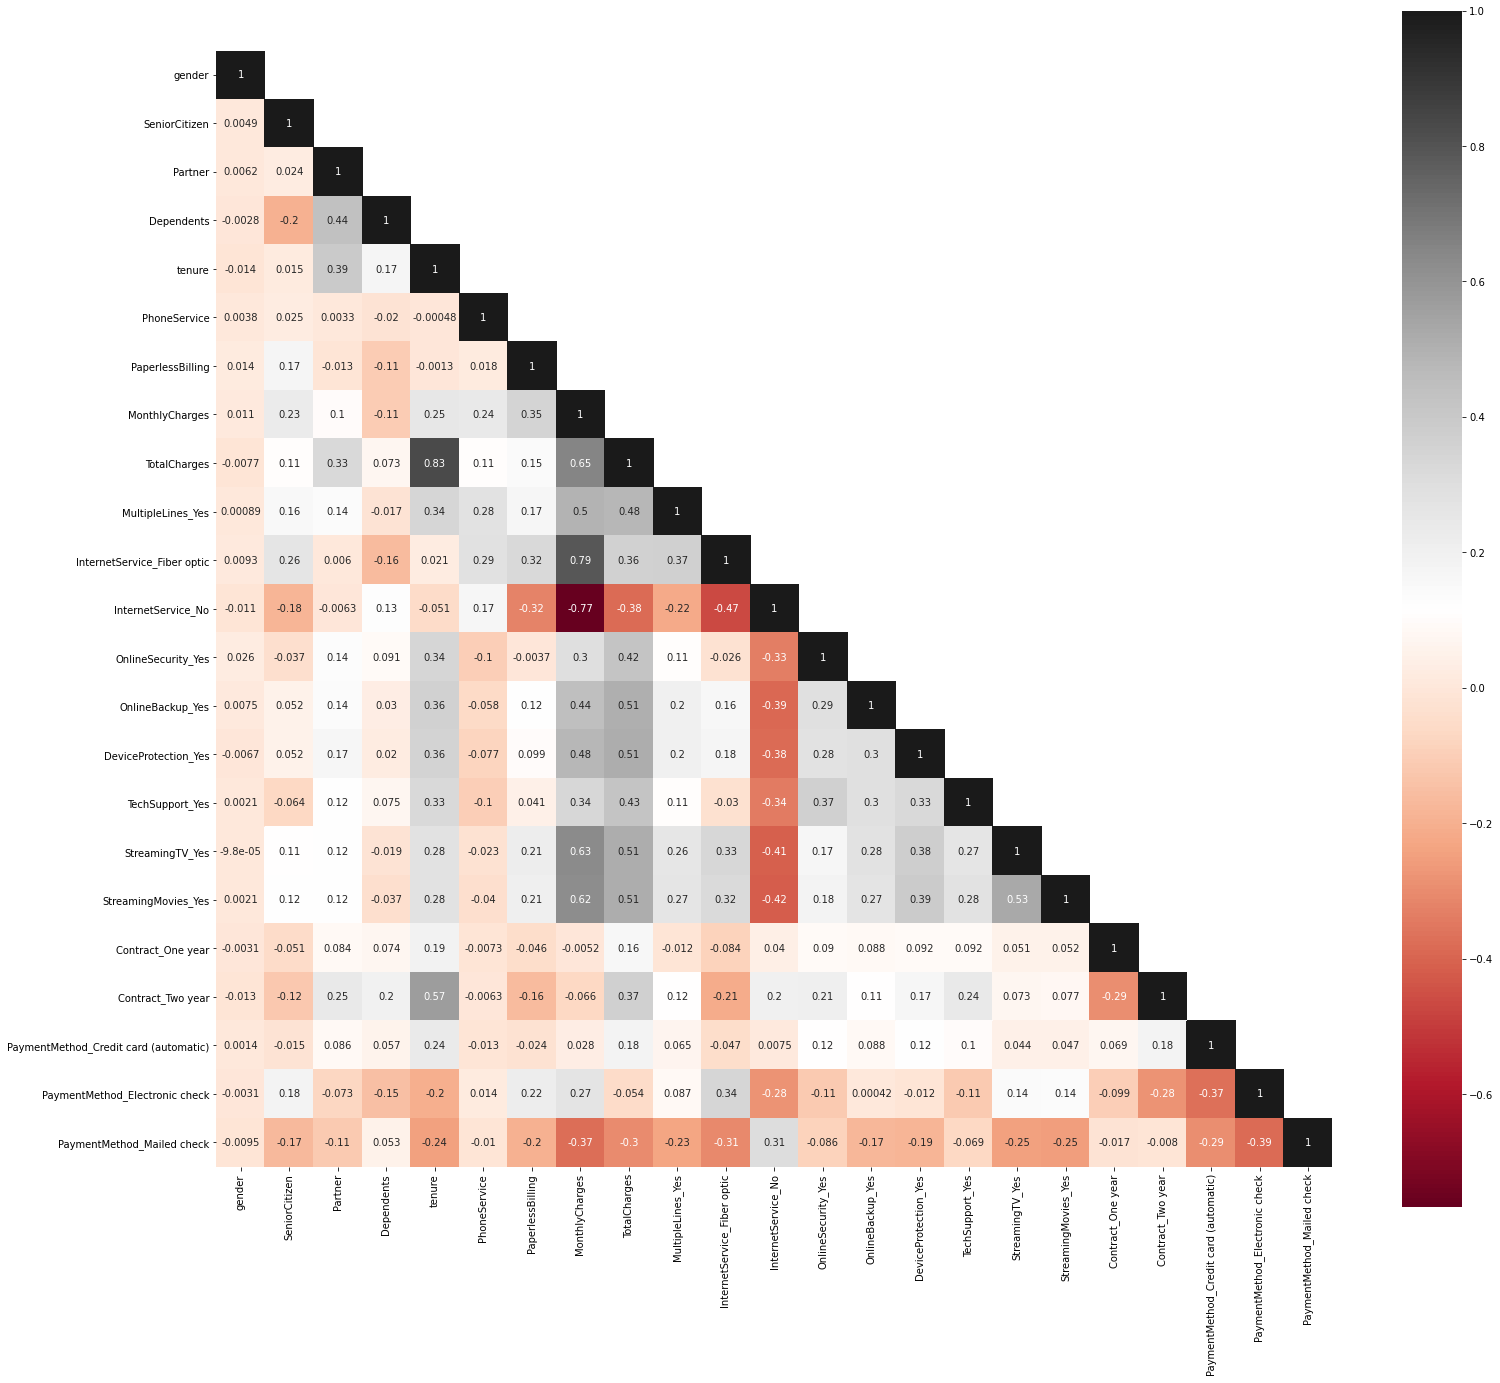

In [ ]:
# plt.figure(figsize = (22,20))
# sns.heatmap(X_train.corr(),annot = True, cmap="viridis")
# plt.show()
cor_mat= X_train.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(25,22)
sns.heatmap(cor_mat,mask=mask,square=True,annot=True,cbar=True,cmap="RdGy")
plt.show()

## Model Building
### Let's start by splitting our data into a training set and a test set.

#### Running Your First Training Model

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Tue, 01 Jun 2021   Deviance:                       4009.4
Time:                        10:11:00   Pearson chi2:                 6.07e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.9728      1.546     -2.570      0.010      -7.002      -0.943
gender                                    0.0346      0.078      0.442      0.658      -0.119       0.188
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
tenure                                   -1.5172      0.189     -8.015      0.000      -1.888      -1.146
PhoneService                              0.9507      0.789      1.205      0.228      -0.595       2.497
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
MonthlyCharges                           -2.1806      1.160     -1.880      0.060      -4.454       0.092
TotalCharges                              0.7332      0.198      3.705      0.000       0.345       1.121
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -2.7792      0.982     -2.831      0.005      -4.703      -0.855
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_Yes                       0.8484      0.396      2.143      0.032       0.072       1.624
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
=========================================================================================================
"""

## Feature Selection Using RFE

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             # running RFE with 13 variables as output
rfe = rfe.fit(X_train, y_train)

In [ ]:
rfe.support_

array([False,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True])

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('gender', False, 8),
 ('SeniorCitizen', True, 1),
 ('Partner', False, 7),
 ('Dependents', False, 6),
 ('tenure', True, 1),
 ('PhoneService', False, 3),
 ('PaperlessBilling', True, 1),
 ('MonthlyCharges', True, 1),
 ('TotalCharges', True, 1),
 ('MultipleLines_Yes', True, 1),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', True, 1),
 ('OnlineSecurity_Yes', False, 2),
 ('OnlineBackup_Yes', False, 5),
 ('DeviceProtection_Yes', False, 9),
 ('TechSupport_Yes', True, 1),
 ('StreamingTV_Yes', True, 1),
 ('StreamingMovies_Yes', True, 1),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaymentMethod_Credit card (automatic)', True, 1),
 ('PaymentMethod_Electronic check', False, 4),
 ('PaymentMethod_Mailed check', True, 1)]

In [ ]:
col = X_train.columns[rfe.support_]

In [ ]:
col

Index(['SeniorCitizen', 'tenure', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
X_train.columns[~rfe.support_]

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'PaymentMethod_Electronic check'],
      dtype='object')

## Assessing the model with StatsModels

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4906
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.1
Date:                Tue, 01 Jun 2021   Deviance:                       4022.2
Time:                        10:12:24   Pearson chi2:                 6.25e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2462      0.189    -11.879      0.000      -2.617      -1.876
SeniorCitizen                             0.4296      0.100      4.312      0.000       0.234       0.625
tenure                                   -1.5596      0.187     -8.334      0.000      -1.926      -1.193
PaperlessBilling                          0.3436      0.090      3.832      0.000       0.168       0.519
MonthlyCharges                           -0.9692      0.199     -4.878      0.000      -1.359      -0.580
TotalCharges                              0.7421      0.197      3.764      0.000       0.356       1.128
MultipleLines_Yes                         0.3779      0.104      3.640      0.000       0.174       0.581
InternetService_Fiber optic               1.5865      0.216      7.342      0.000       1.163       2.010
InternetService_No                       -1.6897      0.216     -7.830      0.000      -2.113      -1.267
TechSupport_Yes                          -0.2408      0.109     -2.210      0.027      -0.454      -0.027
StreamingTV_Yes                           0.5796      0.114      5.102      0.000       0.357       0.802
StreamingMovies_Yes                       0.4665      0.111      4.197      0.000       0.249       0.684
Contract_One year                        -0.6830      0.128     -5.342      0.000      -0.934      -0.432
Contract_Two year                        -1.2931      0.211     -6.138      0.000      -1.706      -0.880
PaymentMethod_Credit card (automatic)    -0.3724      0.113     -3.308      0.001      -0.593      -0.152
PaymentMethod_Mailed check               -0.3723      0.111     -3.345      0.001      -0.591      -0.154
=========================================================================================================
"""

In [ ]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

879     0.192642
5790    0.275624
6498    0.599507
880     0.513571
2784    0.648233
3874    0.414846
5387    0.431184
6623    0.801788
4465    0.228194
5364    0.504575
dtype: float64

In [ ]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.19264205, 0.27562384, 0.59950707, 0.51357126, 0.64823272,
       0.41484553, 0.43118361, 0.80178789, 0.22819404, 0.50457542])

### Creating a dataframe with the actual churn flag and the predicted probabilities

In [ ]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.192642,879
1,0,0.275624,5790
2,1,0.599507,6498
3,1,0.513571,880
4,1,0.648233,2784


### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [ ]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

#y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)
# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.192642,879,0
1,0,0.275624,5790,0
2,1,0.599507,6498,1
3,1,0.513571,880,1
4,1,0.648233,2784,1


In [ ]:
## Creating a Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sn 
%matplotlib inline
from sklearn import metrics

In [ ]:
def draw_cm( actual, predicted ): 
    ## Cret
    cm = metrics.confusion_matrix( actual, predicted, [0,1] ) 
    sn.heatmap(cm, annot=True, fmt='.2f', cmap="Greens",
    xticklabels = ["Not Churn", "Churn"] ,
    yticklabels = ["Not Churn", "Churn"] ) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.show()

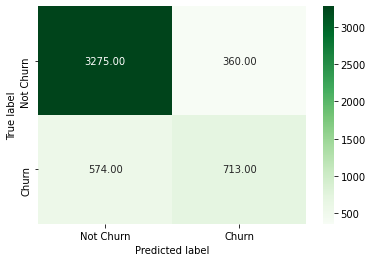

In [ ]:
#Invoking the function
draw_cm( y_train_pred_final.Churn, y_train_pred_final.predicted  )

In [ ]:
## Measuring Accuracies

# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8102397399431126


In [ ]:
print( metrics.classification_report( y_train_pred_final.Churn, y_train_pred_final.predicted ) )

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3635
           1       0.66      0.55      0.60      1287

    accuracy                           0.81      4922
   macro avg       0.76      0.73      0.74      4922
weighted avg       0.80      0.81      0.80      4922



## Checking VIFs

In [ ]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,MonthlyCharges,14.85
4,TotalCharges,10.42
1,tenure,7.38
6,InternetService_Fiber optic,5.61
7,InternetService_No,5.27
12,Contract_Two year,3.14
9,StreamingTV_Yes,2.79
10,StreamingMovies_Yes,2.79
2,PaperlessBilling,2.76
5,MultipleLines_Yes,2.38


##### There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. The variable 'PhoneService' has the highest VIF. So let's start by dropping that.

In [ ]:
col = col.drop('MonthlyCharges', 1)
col

Index(['SeniorCitizen', 'tenure', 'PaperlessBilling', 'TotalCharges',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4907
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.1
Date:                Tue, 01 Jun 2021   Deviance:                       4046.2
Time:                        10:17:24   Pearson chi2:                 5.80e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5971      0.130    -12.296      0.000      -1.852      -1.343
SeniorCitizen                             0.4569      0.099      4.601      0.000       0.262       0.652
tenure                                   -1.3286      0.180     -7.401      0.000      -1.681      -0.977
PaperlessBilling                          0.3533      0.089      3.958      0.000       0.178       0.528
TotalCharges                              0.4347      0.186      2.340      0.019       0.071       0.799
MultipleLines_Yes                         0.1700      0.094      1.814      0.070      -0.014       0.354
InternetService_Fiber optic               0.6888      0.109      6.297      0.000       0.474       0.903
InternetService_No                       -0.9555      0.156     -6.120      0.000      -1.262      -0.649
TechSupport_Yes                          -0.4371      0.101     -4.307      0.000      -0.636      -0.238
StreamingTV_Yes                           0.2881      0.096      2.996      0.003       0.100       0.477
StreamingMovies_Yes                       0.1944      0.096      2.031      0.042       0.007       0.382
Contract_One year                        -0.7289      0.127     -5.729      0.000      -0.978      -0.480
Contract_Two year                        -1.3277      0.210     -6.322      0.000      -1.739      -0.916
PaymentMethod_Credit card (automatic)    -0.3870      0.112     -3.442      0.001      -0.607      -0.167
PaymentMethod_Mailed check               -0.3618      0.110     -3.274      0.001      -0.578      -0.145
=========================================================================================================
"""

In [ ]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

array([0.22790197, 0.22864388, 0.67489226, 0.61586836, 0.66226032,
       0.41819928, 0.28813321, 0.7951366 , 0.17433167, 0.51908788])

In [ ]:
y_train_pred_final['Churn_Prob'] = y_train_pred
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.227902,879,0
1,0,0.228644,5790,0
2,1,0.674892,6498,1
3,1,0.615868,880,1
4,1,0.662260,2784,1


In [ ]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8057700121901666


##### So overall the accuracy hasn't dropped much.

#### Let's check the VIFs again

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,TotalCharges,7.46
1,tenure,6.90
11,Contract_Two year,3.07
5,InternetService_Fiber optic,2.96
9,StreamingMovies_Yes,2.62
8,StreamingTV_Yes,2.59
2,PaperlessBilling,2.55
6,InternetService_No,2.44
4,MultipleLines_Yes,2.27
7,TechSupport_Yes,1.95


In [ ]:
# Let's drop TotalCharges since it has a high VIF
col = col.drop('TotalCharges')
col

Index(['SeniorCitizen', 'tenure', 'PaperlessBilling', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4908
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.9
Date:                Tue, 01 Jun 2021   Deviance:                       4051.9
Time:                        10:18:49   Pearson chi2:                 5.25e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.6577      0.127    -13.094      0.000      -1.906      -1.410
SeniorCitizen                             0.4597      0.100      4.613      0.000       0.264       0.655
tenure                                   -0.9426      0.065    -14.480      0.000      -1.070      -0.815
PaperlessBilling                          0.3455      0.089      3.877      0.000       0.171       0.520
MultipleLines_Yes                         0.2097      0.092      2.279      0.023       0.029       0.390
InternetService_Fiber optic               0.8052      0.097      8.272      0.000       0.614       0.996
InternetService_No                       -0.9726      0.155     -6.261      0.000      -1.277      -0.668
TechSupport_Yes                          -0.4046      0.101     -4.019      0.000      -0.602      -0.207
StreamingTV_Yes                           0.3390      0.094      3.619      0.000       0.155       0.523
StreamingMovies_Yes                       0.2428      0.093      2.598      0.009       0.060       0.426
Contract_One year                        -0.7218      0.127     -5.702      0.000      -0.970      -0.474
Contract_Two year                        -1.2987      0.208     -6.237      0.000      -1.707      -0.891
PaymentMethod_Credit card (automatic)    -0.3874      0.113     -3.442      0.001      -0.608      -0.167
PaymentMethod_Mailed check               -0.3307      0.110     -3.020      0.003      -0.545      -0.116
=========================================================================================================
"""

In [ ]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

array([0.24581699, 0.26536078, 0.66940978, 0.63097033, 0.68291606,
       0.39952622, 0.27582791, 0.79816753, 0.19878625, 0.52911878])

In [ ]:
y_train_pred_final['Churn_Prob'] = y_train_pred
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.245817,879,0
1,0,0.265361,5790,0
2,1,0.669410,6498,1
3,1,0.630970,880,1
4,1,0.682916,2784,1


In [ ]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8061763510767981


##### The accuracy is still practically the same.
### Let's now check the VIFs again

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,Contract_Two year,2.98
4,InternetService_Fiber optic,2.67
8,StreamingMovies_Yes,2.54
7,StreamingTV_Yes,2.51
2,PaperlessBilling,2.45
3,MultipleLines_Yes,2.24
1,tenure,2.04
5,InternetService_No,2.03
6,TechSupport_Yes,1.92
9,Contract_One year,1.78


#### All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only

In [ ]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[3278,  357],
       [ 597,  690]])

In [ ]:
# Actual/Predicted     not_churn    churn
        # not_churn        3269      366
        # churn            595       692  

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sn 
%matplotlib inline
from sklearn import metrics

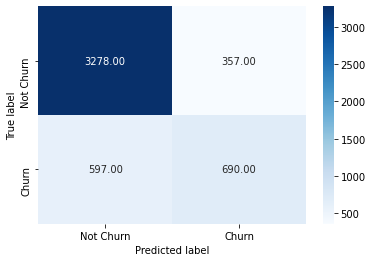

In [ ]:
def draw_cm( actual, predicted ): 
    ## Cret
    cm = metrics.confusion_matrix( actual, predicted, [0,1] ) 
    sn.heatmap(cm, annot=True, fmt='.2f', cmap="Blues",
    xticklabels = ["Not Churn", "Churn"] ,
    yticklabels = ["Not Churn", "Churn"] ) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.show()

#Invoking the function
draw_cm( y_train_pred_final.Churn, y_train_pred_final.predicted  )

In [ ]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.8061763510767981

## Metrics beyond simply accuracy

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5361305361305362

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

0.9017881705639614

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.09821182943603851


In [ ]:
# positive predictive value 
print (TP / float(TP+FP))

0.6590257879656161


In [ ]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8459354838709677


## Plotting the ROC Curve
### An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

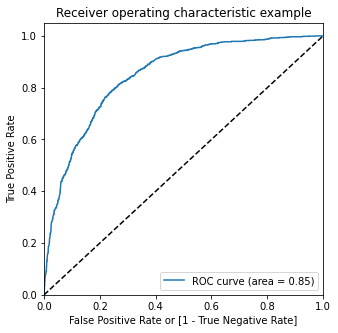

In [ ]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

## Finding Optimal Cutoff Point
##### Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.245817,879,0,1,1,1,0,0,0,0,0,0,0
1,0,0.265361,5790,0,1,1,1,0,0,0,0,0,0,0
2,1,0.669410,6498,1,1,1,1,1,1,1,1,0,0,0
3,1,0.630970,880,1,1,1,1,1,1,1,1,0,0,0
4,1,0.682916,2784,1,1,1,1,1,1,1,1,0,0,0


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.261479  1.000000  0.000000
0.1   0.1  0.614994  0.943279  0.498762
0.2   0.2  0.721861  0.846154  0.677854
0.3   0.3  0.770012  0.776224  0.767813
0.4   0.4  0.790532  0.636364  0.845117
0.5   0.5  0.806176  0.536131  0.901788
0.6   0.6  0.798050  0.380730  0.945805
0.7   0.7  0.776310  0.196581  0.981568
0.8   0.8  0.747867  0.041181  0.998074
0.9   0.9  0.738521  0.000000  1.000000


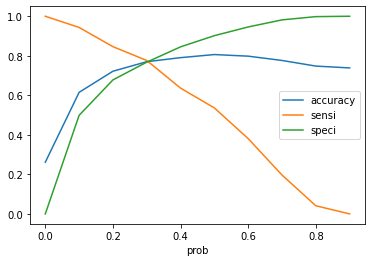

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

## From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.245817,879,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.265361,5790,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.669410,6498,1,1,1,1,1,1,1,1,0,0,0,1
3,1,0.630970,880,1,1,1,1,1,1,1,1,0,0,0,1
4,1,0.682916,2784,1,1,1,1,1,1,1,1,0,0,0,1


In [ ]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.7700121901665989

In [ ]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[2791,  844],
       [ 288,  999]])

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sn 
%matplotlib inline
from sklearn import metrics

In [ ]:
def draw_cm( actual, predicted ): 
    ## Cret
    cm = metrics.confusion_matrix( actual, predicted, [0,1] ) 
    sn.heatmap(cm, annot=True, fmt='.2f', cmap="Purples",
    xticklabels = ["Not Churn", "Churn"] ,
    yticklabels = ["Not Churn", "Churn"] ) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.show()

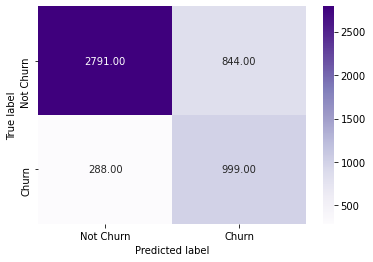

In [ ]:
#Invoking the function
draw_cm( y_train_pred_final.Churn, y_train_pred_final.final_predicted  )

In [ ]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7762237762237763

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

0.7678129298486933

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.23218707015130674


In [ ]:
# Positive predictive value 
print (TP / float(TP+FP))

0.5420510037981552


In [ ]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9064631373822669


## Precision and Recall¶

In [ ]:
#Looking at the confusion matrix again
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion

array([[2791,  844],
       [ 288,  999]])

In [ ]:
# Precision
# TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.5420510037981552

In [ ]:
# Recall
# TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.7762237762237763

In [ ]:
# Using sklearn utilities for the same

from sklearn.metrics import precision_score, recall_score
# ?precision_score
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.6590257879656161

In [ ]:
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.5361305361305362

## Precision and recall tradeoff

In [ ]:
from sklearn.metrics import precision_recall_curve
y_train_pred_final.Churn, y_train_pred_final.predicted

(0       0
 1       0
 2       1
 3       1
 4       1
        ..
 4917    0
 4918    0
 4919    0
 4920    0
 4921    0
 Name: Churn, Length: 4922, dtype: int64, 0       0
 1       0
 2       1
 3       1
 4       1
        ..
 4917    0
 4918    0
 4919    0
 4920    0
 4921    0
 Name: predicted, Length: 4922, dtype: int64)

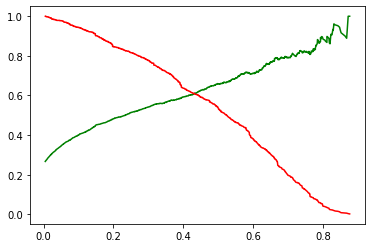

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

## Making predictions on the test set

In [ ]:
X_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges','TotalCharges']])
X_test = X_test[col]
X_test.head()

,SeniorCitizen,tenure,PaperlessBilling,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check
942,0,-0.347623,1,0,1,0,0,0,1,0,0,1,0
3730,0,0.999203,1,1,1,0,0,1,1,0,0,1,0
1761,0,1.040015,1,1,0,1,0,0,0,0,1,1,0
2283,0,-1.286319,1,0,1,0,0,0,0,0,0,0,1
1872,0,0.346196,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
X_test_sm = sm.add_constant(X_test)

Making predictions on the test set

In [ ]:
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

942     0.419725
3730    0.260232
1761    0.008650
2283    0.592626
1872    0.013989
1970    0.692893
2532    0.285289
1616    0.008994
2485    0.602307
5914    0.145153
dtype: float64

In [ ]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
942,0.419725
3730,0.260232
1761,0.008650
2283,0.592626
1872,0.013989


In [ ]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,Churn,CustID,0
0,0,942,0.419725
1,1,3730,0.260232
2,0,1761,0.008650
3,1,2283,0.592626
4,0,1872,0.013989


In [ ]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [ ]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['CustID','Churn','Churn_Prob'], axis=1)


# y_pred_final=
# y_pred_final[x.columns.values]

In [ ]:
# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,Churn,Churn_Prob
0,942,0,0.419725
1,3730,1,0.260232
2,1761,0,0.008650
3,2283,1,0.592626
4,1872,0,0.013989


In [ ]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.42 else 0)
y_pred_final.head()

,CustID,Churn,Churn_Prob,final_predicted
0,942,0,0.419725,0
1,3730,1,0.260232,0
2,1761,0,0.008650,0
3,2283,1,0.592626,1
4,1872,0,0.013989,0


In [ ]:
## Overall Accuracy of the Model
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted)

0.7838862559241706

## Confusion Matrix (Test Predict)

In [ ]:
confusion_final = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted )
confusion_final

array([[1286,  242],
       [ 214,  368]])

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sn 
%matplotlib inline
from sklearn import metrics

In [ ]:
def draw_cm( actual, predicted ): 
    ## Cret
    cm = metrics.confusion_matrix( actual, predicted, [0,1] ) 
    sn.heatmap(cm, annot=True, fmt='.2f', cmap="terrain",
    xticklabels = ["Not Churn", "Churn"] ,
    yticklabels = ["Not Churn", "Churn"] ) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.show()

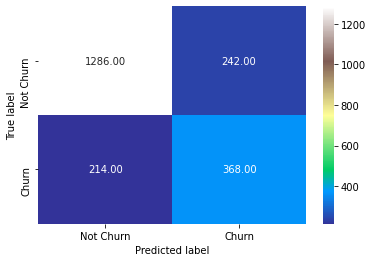

In [ ]:
#Invoking the function
draw_cm( y_pred_final.Churn, y_pred_final.final_predicted )

In [ ]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

## Sensitivity

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7762237762237763

## Specificity

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

0.7678129298486933

In [ ]:
y_test=y_pred_final["Churn"]
y_test

0       0
1       1
2       0
3       1
4       0
       ..
2105    0
2106    0
2107    0
2108    0
2109    0
Name: Churn, Length: 2110, dtype: int64

## Precision & Recall

In [ ]:
y_pred=y_pred_final["final_predicted"]
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1528
           1       0.60      0.63      0.62       582

    accuracy                           0.78      2110
   macro avg       0.73      0.74      0.73      2110
weighted avg       0.79      0.78      0.79      2110



##ROC curve (Area Under Curve)

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.Churn, y_pred_final.Churn_Prob, drop_intermediate = False )

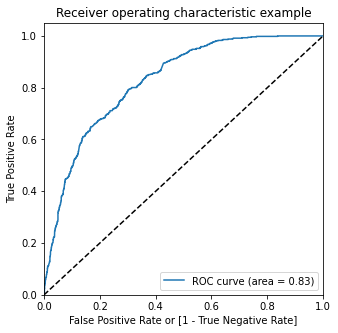

In [ ]:
draw_roc( y_pred_final.Churn, y_pred_final.Churn_Prob)

##Conclusion

Our Model was able to predict the CHURN with 63% recall and 60% precision. In Other words, our model was able to predict- - 63% of actual CHURN cases correctly. - 60% of predicted CHURN has actually churned. Concluding line: Though the prediction metrics are not great, we also understand that the results are purely based on the data quality of the open source data. We have performed multiple threshold optimization steps before arriving at this result. I will update this post soon with a Lift and Gain Chart validation as well.